# **This model will classify a chest xray into Pneumonial or Normal Category**

Using this Pneumonia Detection Model, we can help doctors and medical professionals make faster and more accurate diagnoses of pneumonia, which can lead to better patient outcomes.


[Github Link for similar project that will classify image into three categories](https://github.com/Divyam6969/Pneumonia-Detection-AI)



# Preprocessing

In [32]:
!pip install gradio

# Importing Libraries
(Will import kera library for image classification)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import gradio

# Data preprocessing
(Getting training, validation and testing data set)

In [58]:
import cv2
import os
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train = get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test = get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')
val = get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val')

In [56]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [55]:
positives=[]
negatives=[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else:
        negatives.append(x_train[i])

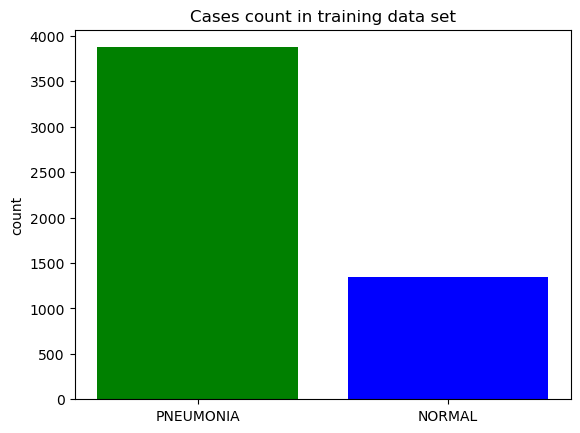

In [54]:
plt.bar(labels, [len(negatives), len(positives)], color=["green", "blue"])
plt.title("Cases count in training data set")
plt.ylabel("count")
plt.show()


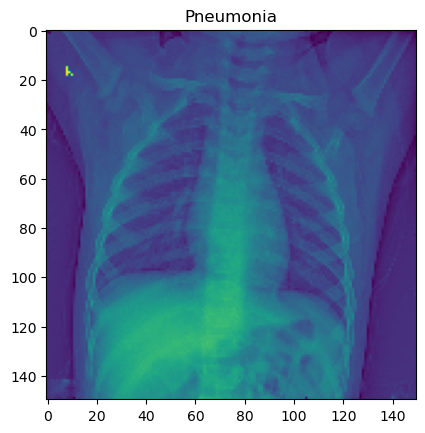

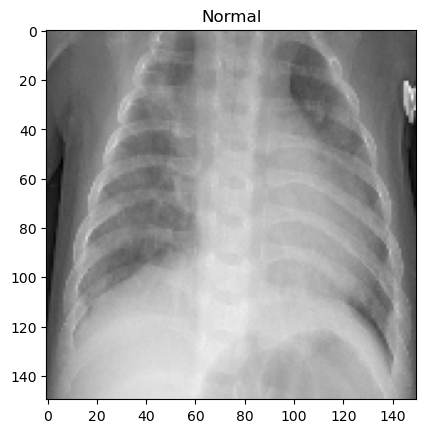

In [53]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4], cmap="gray")
plt.title("Normal")
plt.show()

Performing a grayscale normalization to reduce the effect of illumination's differences

In [52]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

Resizing the data for CNN training and testing

In [51]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [50]:
x_test[0].shape


(150, 150, 1)

In [49]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

# Data augmentation 
(Now I will make a model to classify these X-Rays)

In [48]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()
model.compile(optimizer = "rmsprop" , 
            loss = 'binary_crossentropy' , 
            metrics = ['accuracy'])
# model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 10 , 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = learning_rate_reduction)
model.save_weights('kaggle/saved_model_ai/pneumoniadetection')

# Evaluation Matrix

In [47]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 175ms/step - loss: 0.3249 - accuracy: 0.9151
Loss of the model is -  0.32493919134140015
20/20 [==============================] - 3s 171ms/step - loss: 0.3249 - accuracy: 0.9151
Accuracy of the model is -  91.50640964508057 %


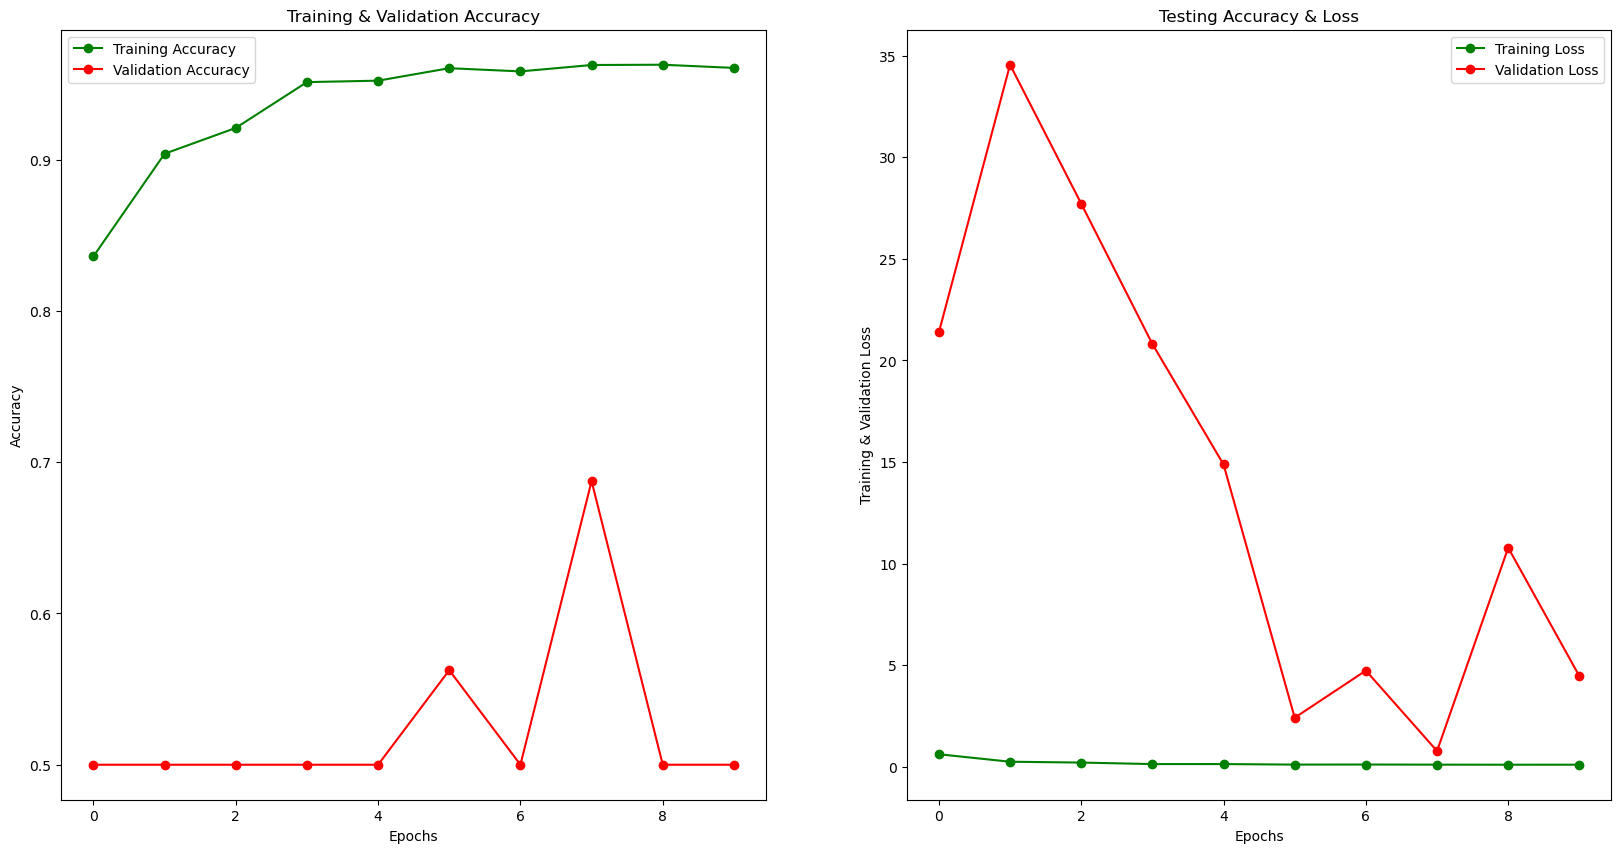

In [46]:
epochs = list(range(10))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [45]:
predictions = model.predict(x_test) 
for i in range(len(predictions)): 
    predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 3s 174ms/step


In [44]:
print(classification_report(y_test, 
                            predictions, 
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.94      0.93       390
   Normal (Class 1)       0.90      0.87      0.88       234

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.91      0.92      0.91       624



# Confusion Matrix

In [43]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
cm

,0,1
0,368,22
1,31,203


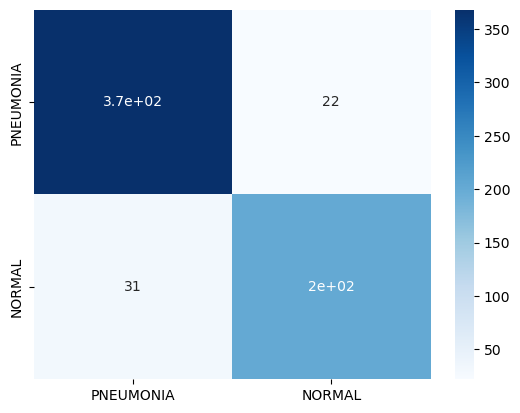

In [42]:
sns.heatmap(cm, cmap="Blues", annot=True, xticklabels = labels,yticklabels = labels)
plt.show()

In [41]:
def pneumoniaPrediction(img):
    if img is not None:
        img = np.array(img)/255
        img = np.array(img)/255
        img = img.reshape(-1, 150, 150, 1)
        isPneumonic = model.predict(img)[0]
        imgClass = "Normal" if isPneumonic<0.5 else "Pneumonic"
        return imgClass
        # perform prediction and return label
    else:
        return None
    

In [40]:
pr = model.predict(x_test)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=1
    else:
        pr[i]=0

20/20 [==============================] - 4s 175ms/step


In [39]:
img = gradio.inputs.Image(shape=(150, 150))
label = gradio.outputs.Label(num_top_classes=1)

In [35]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                            title = "Pneumonia Detection using Chest X-Ray",
                            inputs = img,
                            outputs = label,
                            interpretation = "default")
interface.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a6b3b8285854dce993.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 51ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a6b3b8285854dce993.gradio.live
